In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install -c chembl chembl_structure_pipeline
import chembl_structure_pipeline
from chembl_structure_pipeline import standardizer

In [1]:
from IPython.display import clear_output

# https://www.dgl.ai/pages/start.html

# !pip install dgl
!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html # FOR CUDA VERSION
!pip install dgllife
!pip install rdkit-pypi
!pip install --pre deepchem
!pip install ipython-autotime
!pip install gputil
!pip install psutil
!pip install humanize

%load_ext autotime

clear = clear_output()

time: 4.98 ms (started: 2021-11-30 12:01:10 +00:00)


In [2]:
import os
from os import path
import statistics
import warnings
import random
import time 
import itertools
import psutil
import humanize
import GPUtil as GPU
import subprocess
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import tqdm
from tqdm import trange, tqdm_notebook, tnrange

import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv, SumPooling, MaxPooling
import dgl.function as fn
import dgllife
from dgllife import utils

# embedding
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.tensorboard import SummaryWriter


import sklearn
from sklearn.metrics import (auc, roc_curve, roc_auc_score, average_precision_score, 
                             accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, 
                             f1_score, PrecisionRecallDisplay)
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore", message="DGLGraph.__len__")

DGLBACKEND = 'pytorch'

clear

def get_cmd_output(command):
  return subprocess.check_output(command,
                        stderr=subprocess.STDOUT,
                        shell=True).decode('UTF-8')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


time: 10.2 s (started: 2021-11-30 12:01:10 +00:00)


## Create Dataset

In [5]:
def create_dataset(df, name, bonds):
    print(f"Creating Dataset and Saving to {drive_path}/data/{name}.pkl")
    data = df.sample(frac=1)
    data = data.reset_index(drop=True)
    data['mol'] = data['smiles'].apply(lambda x: create_dgl_features(x, bonds))
    data.to_pickle(f"{drive_path}/data/{name}.pkl")
    return data

def featurize_atoms(mol):
  feats = []
  
  atom_features = utils.ConcatFeaturizer([
    utils.atom_type_one_hot,
    utils.atomic_number_one_hot,
    utils.atom_degree_one_hot,
    utils.atom_explicit_valence_one_hot,
    utils.atom_formal_charge_one_hot,
    utils.atom_num_radical_electrons_one_hot,
    utils.atom_hybridization_one_hot,
    utils.atom_is_aromatic_one_hot
  ])

  for atom in mol.GetAtoms():
    feats.append(atom_features(atom))
  return {'feats': torch.tensor(feats).float()}

def featurize_bonds(mol):
  feats = []
  
  bond_features = utils.ConcatFeaturizer([
    utils.bond_type_one_hot,
    utils.bond_is_conjugated_one_hot,
    utils.bond_is_in_ring_one_hot,
    utils.bond_stereo_one_hot,
    utils.bond_direction_one_hot,
  ])

  for bond in mol.GetBonds():
    feats.append(bond_features(bond))
    feats.append(bond_features(bond))
  return {'edge_feats': torch.tensor(feats).float()}

def create_dgl_features(smiles, bonds):
    mol = Chem.MolFromSmiles(smiles)
    mol = standardizer.standardize_mol(mol)
    
    if bonds:
        dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    edge_featurizer=featurize_bonds,
                                    canonical_atom_order=True)
    else:
      dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    canonical_atom_order=True)
    
    dgl_graph = dgl.add_self_loop(dgl_graph)
    
    return dgl_graph

def load_dataset(dataset, bonds=False, feat='graph', create_new=False):
  """
    dataset values: muv, tox21, dude-gpcr
    feat values: graph, ecfp
  """
  dataset_test_tasks = {
    'tox21': ['SR-HSE', 'SR-MMP', 'SR-p53'],
    'muv': ['MUV-832', 'MUV-846', 'MUV-852', 'MUV-858', 'MUV-859'],
    'dude-gpcr': ['adrb2', 'cxcr4']
  }

  dataset_original = dataset

  if bonds:
    dataset = dataset + "_with_bonds"

  if path.exists(f"{drive_path}/data/{dataset}_dgl.pkl") and not create_new:
    # Load Dataset
    print("Reading Pickle")
    if feat == 'graph':
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_dgl.pkl")
    else:
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_ecfp.pkl")
  else:
    # Create Dataset
    df = pd.read_csv(f"{drive_path}/data/raw/{dataset_original}.csv")
    if feat == 'graph':
      data = create_dataset(df, f"{dataset}_dgl", bonds)
    else:
      data = create_ecfp_dataset(df, f"{dataset}_ecfp")

  test_tasks = dataset_test_tasks.get(dataset_original)
  drop_cols = test_tasks.copy()
  drop_cols.extend(['mol_id', 'smiles', 'mol'])
  train_tasks = [x for x in list(data.columns) if x not in drop_cols]

  train_dfs = dict.fromkeys(train_tasks)
  for task in train_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']
      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)
      train_dfs[task] = df
  for key in train_dfs:
    print(key, len(train_dfs[key]))

  if feat == 'graph':
    feat_length = data.iloc[0].mol.ndata['feats'].shape[-1]
    print("Feature Length", feat_length)

    if with_bonds:
      feat_length = data.iloc[0].mol.edata['edge_feats'].shape[-1]
      print("Feature Length", feat_length)
    else:
      print("Edge Features: ", with_bonds)

  test_dfs = dict.fromkeys(test_tasks)

  for task in test_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']

      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)

      test_dfs[task] = df

  for key in test_dfs:
    print(key, len(test_dfs[key]))

  # return data, train_tasks, test_tasks
  return train_tasks, train_dfs, test_tasks, test_dfs

time: 166 ms (started: 2021-11-30 12:04:55 +00:00)


## Create Episode

In [6]:
def create_episode(n_support_pos, n_support_neg, n_query, data, test=False, train_balanced=True):
  """
    n_query = per class data points
    Xy = dataframe dataset in format [['y', 'mol']]
  """
  support = []
  query = []

  n_query_pos = n_query
  n_query_neg = n_query

  support_neg = data[data['y'] == 0].sample(n_support_neg)
  support_pos = data[data['y'] == 1].sample(n_support_pos)

  # organise support by class in array dimensions
  support.append(support_neg.to_numpy())
  support.append(support_pos.to_numpy())
  support = np.array(support, dtype=object)
  support_X = [rec[1] for sup_class in support for rec in sup_class]
  support_y = np.asarray([rec[0] for sup_class in support for rec in sup_class], dtype=np.float16).flatten()

  data = data.drop(support_neg.index)
  data = data.drop(support_pos.index)

  if len(data[data['y'] == 1]) < n_query:
    n_query_pos = len(data[data['y'] == 1])

  if test:
    # test uses all data remaining
    query_neg = data[data['y'] == 0].to_numpy()
    query_pos = data[data['y'] == 1].to_numpy()
  elif (not test) and train_balanced:
    # for balanced queries, same size as support
    query_neg = data[data['y'] == 0].sample(n_query_neg).to_numpy()
    query_pos = data[data['y'] == 1].sample(n_query_pos).to_numpy()
  elif (not test) and (not train_balanced):
    # print('test')
    query_neg = data[data['y'] == 0].sample(1).to_numpy()
    query_pos = data[data['y'] == 1].sample(1).to_numpy()

    query_rem = data.sample(n_query*2 - 2)
    query_neg_rem = query_rem[query_rem['y'] == 0].to_numpy()
    query_pos_rem = query_rem[query_rem['y'] == 1].to_numpy()

    query_neg = np.concatenate((query_neg, query_neg_rem))
    query_pos = np.concatenate((query_pos, query_pos_rem), axis=0)

  query_X = np.concatenate([query_neg[:, 1], query_pos[:, 1]])
  query_y = np.concatenate([query_neg[:, 0], query_pos[:, 0]])
  
  return support_X, support_y, query_X, query_y

time: 40.9 ms (started: 2021-11-30 12:04:57 +00:00)


In [ ]:
# task = 'NR-AR'
# df = data[[task, 'mol']]
# df = df.dropna()
# df.columns = ['y', 'mol']

# support_X, support_y, query_X, query_y = create_episode(1, 1, 64, df)

# support_y


# testing
# support = []
# query = []

# support_neg = df[df['y'] == 0].sample(2)
# support_pos = df[df['y'] == 1].sample(2)

# # organise support by class in array dimensions
# support.append(support_neg.to_numpy())
# support.append(support_pos.to_numpy())
# support = np.array(support)
# support.shape

# support[:, :, 1]

time: 2.4 ms (started: 2021-11-27 23:09:54 +00:00)


## Graph Embedding

In [7]:
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels=128):
      super(GCN, self).__init__()
      self.conv1 = GraphConv(in_channels, 64)
      self.conv2 = GraphConv(64, 128)
      self.conv3 = GraphConv(128, 64)
      self.sum_pool = SumPooling()
      self.dense = nn.Linear(64, out_channels)

    def forward(self, graph, in_feat):
        h = self.conv1(graph, in_feat)
        h = F.relu(h)
        graph.ndata['h'] = h       
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))
      
        h = self.conv2(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        h = self.conv3(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        output = self.sum_pool(graph, graph.ndata['h'])
        output = torch.tanh(output)
        output = self.dense(output)
        output = torch.tanh(output)
        return output

time: 19 ms (started: 2021-11-30 12:05:00 +00:00)


## Matching Networks

[GitABCWorld - Matching Networks](https://github.com/gitabcworld/MatchingNetworks)



### Distance Fn

In [8]:
class DistanceNetwork(nn.Module):
  """
  Produces pdfs over the support set classes for the target set image.
  :param support_set: The embeddings of the support set images, tensor of shape [sequence_length, batch_size, 64]
  :param input_image: The embedding of the target image, tensor of shape [batch_size, 64]
  :return: Softmax pdf. Tensor with cosine similarities of shape [batch_size, sequence_length]
  """

  def __init__(self):
    super(DistanceNetwork, self).__init__()

  def forward(self, support_set, query_mol):
    similarities = []
    
    for support_mol in support_set:
      similarities.append(nn.CosineSimilarity(dim=0)(support_mol.unsqueeze(1), query_mol))

    similarities = torch.stack(similarities)
    return similarities

time: 6.28 ms (started: 2021-11-30 12:05:03 +00:00)


### ResiLSTM Embedding

Unlike the AttnLSTM model which only modifies the test vectors additively, this model allows for an additive update to be performed to both test and support using information from each other.


In [9]:
def cos(x, y):
  transpose_shape = tuple(list(range(len(y.shape)))[::-1])

  x = x.float()

  denom = (
      torch.sqrt(torch.sum(torch.square(x)) *
                     torch.sum(torch.square(y))) + torch.finfo(torch.float32).eps)

  return torch.matmul(x, torch.permute(y, transpose_shape)) / denom


time: 4.15 ms (started: 2021-11-30 12:05:05 +00:00)


In [10]:
class ResiLSTMEmbedding(nn.Module):
  def __init__(self, n_support, n_feat=128, max_depth=3):
    super(ResiLSTMEmbedding, self).__init__()

    self.max_depth = max_depth
    self.n_support = n_support
    self.n_feat = n_feat

    self.support_lstm = nn.LSTMCell(input_size=2*self.n_feat, hidden_size=self.n_feat)
    self.q_init = torch.nn.Parameter(torch.zeros((self.n_support, self.n_feat), dtype=torch.float, device="cuda"))
    self.support_states_init_h = torch.nn.Parameter(torch.zeros(self.n_support, self.n_feat))
    self.support_states_init_c = torch.nn.Parameter(torch.zeros(self.n_support, self.n_feat))
  
    self.query_lstm = nn.LSTMCell(input_size=2*self.n_feat, hidden_size=self.n_feat)

    if torch.cuda.is_available():
      self.support_lstm = self.support_lstm.cuda()
      self.query_lstm = self.query_lstm.cuda()
      self.q_init = self.q_init.cuda()
  
  def forward(self, x_support, x_query):
    self.p_init = torch.zeros((len(x_query), self.n_feat)).to(device)
    self.query_states_init_h = torch.zeros(len(x_query), self.n_feat).to(device)
    self.query_states_init_c = torch.zeros(len(x_query), self.n_feat).to(device)

    x_support = x_support
    x_query = x_query
    z_support = x_support
    q = self.q_init
    p = self.p_init
    support_states_h = self.support_states_init_h
    support_states_c = self.support_states_init_c
    query_states_h = self.query_states_init_h
    query_states_c = self.query_states_init_c

    for i in range(self.max_depth):
      sup_e = cos(z_support + q, x_support)
      sup_a = torch.nn.functional.softmax(sup_e, dim=-1)
      sup_r = torch.matmul(sup_a, x_support).float()

      query_e = cos(x_query + p, z_support)
      query_a = torch.nn.functional.softmax(query_e, dim=-1)
      query_r = torch.matmul(query_a, z_support).float()

      sup_qr = torch.cat((q, sup_r), 1)
      support_hidden, support_out = self.support_lstm(sup_qr, (support_states_h, support_states_c))
      q = support_hidden

      query_pr = torch.cat((p, query_r), 1)
      query_hidden, query_out = self.query_lstm(query_pr, (query_states_h, query_states_c))
      p = query_hidden

      z_support = sup_r

    return x_support + q, x_query + p

time: 60.3 ms (started: 2021-11-30 12:05:06 +00:00)


### Matching Net

In [11]:
class MatchingNet(nn.Module):
  def __init__(self, with_bonds=False):
    """
    Matching Network
    """
    super(MatchingNet, self).__init__()

    self.dn = DistanceNetwork()

    if torch.cuda.is_available():
      self.dn = self.dn.cuda()

  def forward(self, emb_support, emb_query, one_hot_support_y):

    y_hats = torch.tensor([])
    pred_logits = torch.tensor([])

    if torch.cuda.is_available(): 
      pred_logits = pred_logits.cuda()
      y_hats = y_hats.cuda()
    
    for i, query in enumerate(emb_query):
        similarities = self.dn(emb_support, query.unsqueeze(0).permute(1, 0))

        # attention = torch.nn.functional.softmax(similarities, dim=-1) # might delete
        attention = similarities

        prediction_logits = torch.matmul(attention.squeeze(1).float(), one_hot_support_y.float()).unsqueeze(0)

        pred_logits = torch.cat((pred_logits, prediction_logits), 0)

    return pred_logits

time: 17.6 ms (started: 2021-11-30 12:05:09 +00:00)


## Training Loop

In [18]:
def train(train_tasks, train_dfs, balanced_queries, k_pos, k_neg, n_query, episodes, lr):
  
  writer = SummaryWriter()
  start_time = time.time()

  node_feat_size = 177
  embedding_size = 128

  encoder = GCN(node_feat_size, embedding_size)
  resi_lstm = ResiLSTMEmbedding(k_pos+k_neg)
  matching_net = MatchingNet()
  loss_fn = nn.MSELoss()

  if torch.cuda.is_available(): 
    encoder = encoder.cuda()
    resi_lstm = resi_lstm.cuda()
    matching_net = matching_net.cuda()
    loss_fn = loss_fn.cuda()

  encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = lr)
  lstm_optimizer = torch.optim.Adam(resi_lstm.parameters(), lr = lr)
  
  encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, patience=200, verbose=False)
  lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(lstm_optimizer, patience=200, verbose=False)
  
  episode_num = 1
  early_stop = False
  losses = []
  
  running_loss = 0.0
  running_acc = 0.0
  running_roc = 0.0
  running_prc = 0.0

  pbar = trange(episodes, desc=f"Training")
  for episode in pbar:
    episode_loss = 0.0

    # SET TRAINING MODE
    encoder.train()
    resi_lstm.train()
    matching_net.train()

    # RANDOMISE ORDER OF TASKS PER EPISODE
    shuffled_train_tasks = random.sample(train_tasks, len(train_tasks))

    # LOOP OVER TASKS
    for task in shuffled_train_tasks:
      X = train_dfs[task]
      X_support, y_support, X_query, y_query = create_episode(k_pos, k_neg, n_query, X, False, balanced_queries)

      total_query = int((y_query == 0).sum() + (y_query == 1).sum())

      target_inds = torch.from_numpy(y_query.astype('float32')).float()
      target_inds = target_inds.unsqueeze(1).type(torch.int64)
      targets = Variable(target_inds, requires_grad=False).to(device)

      # ONE HOT SUPPORT TARGETS
      y_support = torch.tensor(y_support, dtype=int)
      support_set_one_hot_y = F.one_hot(y_support, num_classes=2)
      
      # ONE HOT QUERY TARGETS
      query_targets = torch.from_numpy(y_query.astype('int'))
      one_hot_queries = torch.zeros(total_query, 2) # n-way 2
      one_hot_queries[torch.arange(total_query), query_targets] = 1
      one_hot = torch.autograd.Variable(one_hot_queries)

      if torch.cuda.is_available(): 
        targets=targets.cuda()
        one_hot_queries=one_hot_queries.cuda()
        support_set_one_hot_y = support_set_one_hot_y.cuda()

      n_support = k_pos + k_neg
      X = X_support + list(X_query)

      # CREATE EMBEDDINGS
      dataloader = GraphDataLoader(X, batch_size=(n_support + total_query), shuffle=False, pin_memory=True)
      for graph in dataloader:
        graph = graph.to(device)
        
        if with_bonds:
          embeddings = encoder.forward(graph, (graph.ndata['feats'].float(), graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
        else:
          embeddings = encoder.forward(graph, graph.ndata['feats'].float()) # FOR NODES ONLY

      # LSTM EMBEDDINGS
      emb_support = embeddings[:n_support]
      emb_query = embeddings[n_support:]
      lstm_support, lstm_query = resi_lstm(emb_support, emb_query)

      # def forward(self, emb_support, emb_query, one_hot_support_y, k_pos, k_neg):

      # MATCHING NET
      logits = matching_net(lstm_support, lstm_query, support_set_one_hot_y)

      # LOSS FUNCTION
      loss = loss_fn(logits, one_hot_queries)

      # BACK PROP
      encoder.zero_grad()
      resi_lstm.zero_grad()
      matching_net.zero_grad()

      loss.backward()
          
      encoder_optimizer.step()
      lstm_optimizer.step()

      _, y_hats = logits.max(1)
      
      preds = y_hats.detach().cpu()

      roc = roc_auc_score(query_targets, preds)
      prc = average_precision_score(query_targets, preds)
      acc = accuracy_score(query_targets, preds)

      episode_loss += loss.item()
      running_loss += loss.item()
      running_acc += acc
      running_roc += roc
      running_prc += prc

    pbar.set_description(f"Episode {episode_num} - Loss {loss.item():.6f} - Acc {acc:.4f} - LR {encoder_optimizer.param_groups[0]['lr']}")
    pbar.refresh()

    losses.append(episode_loss / len(train_tasks))
    writer.add_scalar('Loss/train', episode_loss / len(train_tasks), episode_num)

    if encoder_optimizer.param_groups[0]['lr'] < 0.000001:
      break # EARLY STOP
    elif episode_num < episodes:
      episode_num += 1

    encoder_scheduler.step(loss)
    lstm_scheduler.step(loss)

  epoch_loss = running_loss / (episode_num*len(train_tasks))
  epoch_acc = running_acc / (episode_num*len(train_tasks))
  epoch_roc = running_roc / (episode_num*len(train_tasks))
  epoch_prc = running_prc / (episode_num*len(train_tasks))

  print(f'Loss: {epoch_loss:.5f} Acc: {epoch_acc:.4f} ROC: {epoch_roc:.4f} PRC: {epoch_prc:.4f}')

  end_time = time.time()

  train_info = {
      "losses": losses,
      "duration": str(timedelta(seconds=(end_time - start_time))),
      "episodes": episode_num,
      "train_roc": epoch_roc,
      "train_prc": epoch_prc
  }

  return encoder, resi_lstm, matching_net, train_info

time: 235 ms (started: 2021-11-30 12:08:33 +00:00)


## Testing Loop

In [12]:
def test(encoder, lstm, matching_net, test_tasks, test_dfs, k_pos, k_neg, rounds):
  encoder.eval()
  lstm.eval()
  matching_net.eval()

  test_info = {}

  with torch.no_grad():
    for task in test_tasks:

      Xy = test_dfs[task]

      running_loss = []
      running_acc = []
      running_roc = [0]
      running_prc = [0]

      running_preds = []
      running_targets = []
      running_actuals = []

      for round in trange(rounds):
        X_support, y_support, X_query, y_query = create_episode(k_pos, k_neg, n_query=0, data=Xy, test=True, train_balanced=False)
        
        total_query = int((y_query == 0).sum() + (y_query == 1).sum())
        n_support = k_pos + k_neg
        X = X_support + list(X_query)

        # ONE HOT SUPPORT TARGETS
        y_support = torch.tensor(y_support, dtype=int)
        support_set_one_hot_y = F.one_hot(y_support, num_classes=2)

        if torch.cuda.is_available(): 
          support_set_one_hot_y = support_set_one_hot_y.cuda()

        dataloader = GraphDataLoader(X, batch_size=(n_support + total_query), shuffle=False, pin_memory=True)
        for graph in dataloader:
          graph = graph.to(device)
          if with_bonds:
            embeddings = encoder.forward(graph, (graph.ndata['feats'].float(), graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
          else:
            embeddings = encoder.forward(graph, graph.ndata['feats'].float()) # FOR NODES ONLY

        emb_support = embeddings[:n_support]
        emb_query = embeddings[n_support:]
        emb_support, emb_query = lstm(emb_support, emb_query)

        logits = matching_net(emb_support, emb_query, support_set_one_hot_y)

        # _, y_hat = logits.max(1)
        _, y_hat_actual = logits.max(1)
        y_hat = logits[:, 1]

        target_inds = torch.from_numpy(y_query.astype('float32')).float()
        target_inds = target_inds.unsqueeze(1).type(torch.int64)
        targets = Variable(target_inds, requires_grad=False)
        y_hat = y_hat.squeeze().detach().cpu()

        roc = roc_auc_score(targets, y_hat)
        prc = average_precision_score(targets, y_hat)
        # acc = accuracy_score(targets, y_hat)

        running_preds.append(y_hat)
        running_actuals.append(y_hat_actual)
        running_targets.append(targets)

        # running_acc.append(acc)
        running_roc.append(roc)
        running_prc.append(prc)

      median_index = running_roc.index(statistics.median(running_roc))
      if median_index == rounds:
        median_index = median_index - 1
      chart_preds = running_preds[median_index]
      chart_actuals = running_actuals[median_index].detach().cpu()
      chart_targets = running_targets[median_index]

      c_auc = roc_auc_score(chart_targets, chart_preds)
      c_fpr, c_tpr, _ = roc_curve(chart_targets, chart_preds)
      plt.plot(c_fpr, c_tpr, marker='.', label = 'AUC = %0.2f' % c_auc)
      plt.plot([0, 1], [0, 1],'r--', label='No Skill')
      # plt.plot([0, 0, 1], [0, 1, 1], 'g--', label='Perfect Classifier')
      plt.title('Receiver Operating Characteristic')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend(loc = 'best')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/roc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      # prc_graph = PrecisionRecallDisplay.from_predictions(chart_targets, chart_preds)
      c_precision, c_recall, _ = precision_recall_curve(chart_targets, chart_preds)
      plt.title('Precision Recall Curve')
      # plt.plot([0, 1], [0, 0], 'r--', label='No Skill')
      no_skill = len(chart_targets[chart_targets==1]) / len(chart_targets)
      plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
      # plt.plot([0, 1, 1], [1, 1, 0], 'g--', label='Perfect Classifier')
      plt.plot(c_recall, c_precision, marker='.', label = 'AUC = %0.2f' % auc(c_recall, c_precision))
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.legend(loc = 'best')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/prc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      cm = ConfusionMatrixDisplay.from_predictions(chart_targets, chart_actuals)
      plt.title('Confusion Matrix')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/cm_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      running_roc.pop(0) # remove the added 0
      running_prc.pop(0) # remove the added 0 
      # round_acc = f"{statistics.mean(running_acc):.3f} \u00B1 {statistics.stdev(running_acc):.3f}"
      round_roc = f"{statistics.mean(running_roc):.3f} \u00B1 {statistics.stdev(running_roc):.3f}"
      round_prc = f"{statistics.mean(running_prc):.3f} \u00B1 {statistics.stdev(running_prc):.3f}"

      test_info[task] = {
          # "acc": round_acc,
          "roc": round_roc,
          "prc": round_prc,
          "roc_values": running_roc,
          "prc_values": running_prc
      }

      print(f'Test {task}')
      # print(f"Acc: {round_acc}")
      print(f"ROC: {round_roc}")
      print(f"PRC: {round_prc}")

    return targets, y_hat, test_info

time: 174 ms (started: 2021-11-30 12:05:13 +00:00)


## Initiate Training and Testing

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.49 ms (started: 2021-11-30 12:05:17 +00:00)


In [15]:
# PATHS

drive_path = "/content/drive/MyDrive/Colab Notebooks/MSC_21"
method_dir = "MatchingNets"
log_path = f"{drive_path}/{method_dir}/logs/"

# PARAMETERS

dataset = 'dude-gpcr'
with_bonds = False 
test_rounds = 20
n_query = 64 # per class
episodes = 5000
lr = 0.001
balanced_queries = True

time: 5.49 ms (started: 2021-11-30 12:05:27 +00:00)


In [16]:
#FOR DETERMINISTIC REPRODUCABILITY
randomseed = 12
torch.manual_seed(randomseed) 
np.random.seed(randomseed)
random.seed(randomseed)
torch.cuda.manual_seed(randomseed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.is_available()
torch.backends.cudnn.benchmark = False # selects fastest conv algo
torch.backends.cudnn.deterministic = True

# LOAD DATASET
# data, train_tasks, test_tasks = load_dataset(dataset, bonds=with_bonds, create_new=False)

train_tasks, train_dfs, test_tasks, test_dfs = load_dataset(dataset, bonds=with_bonds, feat='graph', create_new=False)

# print(dataset)

# train_dfs = dict.fromkeys(train_tasks)
# for task in train_tasks:
#     df = data[[task, 'mol']].dropna()
#     df.columns = ['y', 'mol']
#     # FOR BOND INFORMATION
#     if with_bonds:
#       for index, r in df.iterrows():
#         if r.mol.edata['edge_feats'].shape[-1] < 17:
#           df.drop(index, inplace=True)
#     train_dfs[task] = df
# for key in train_dfs:
#   print(key, len(train_dfs[key]))

# feat_length = data.iloc[0].mol.ndata['feats'].shape[-1]
# print("Feature Length", feat_length)

# if with_bonds:
#   feat_length = data.iloc[0].mol.edata['edge_feats'].shape[-1]
#   print("Feature Length", feat_length)
# else:
#   print("Edge Features: ", with_bonds)

# test_dfs = dict.fromkeys(test_tasks)

# for task in test_tasks:
#     df = data[[task, 'mol']].dropna()
#     df.columns = ['y', 'mol']

#     # FOR BOND INFORMATION
#     if with_bonds:
#       for index, r in df.iterrows():
#         if r.mol.edata['edge_feats'].shape[-1] < 17:
#           df.drop(index, inplace=True)

#     test_dfs[task] = df

# for key in test_dfs:
#   print(key, len(test_dfs[key]))

Reading Pickle
aa2ar 32032
drd3 34530
adrb1 16097
Feature Length 177
Edge Features:  False
adrb2 15231
cxcr4 3446
time: 57.2 s (started: 2021-11-30 12:06:24 +00:00)



RUNNING 1+/10-


Episode 2730 - Loss 0.014905 - Acc 0.9922 - LR 1.0000000000000002e-07:  55%|█████▍    | 2729/5000 [2:09:48<1:48:00,  2.85s/it]


Loss: 0.06800 Acc: 0.9696 ROC: 0.9696 PRC: 0.9571


100%|██████████| 20/20 [09:26<00:00, 28.32s/it]


Test adrb2
ROC: 0.999 ± 0.000
PRC: 0.975 ± 0.002


100%|██████████| 20/20 [02:08<00:00,  6.41s/it]


Test cxcr4
ROC: 0.764 ± 0.021
PRC: 0.066 ± 0.027


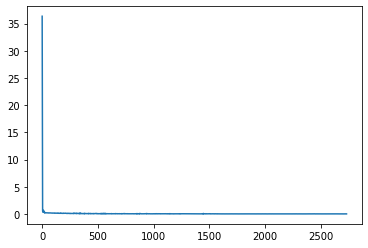

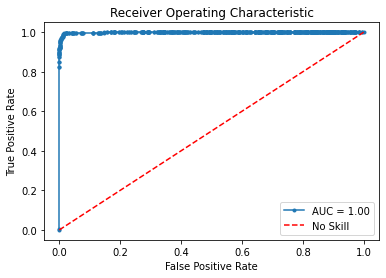

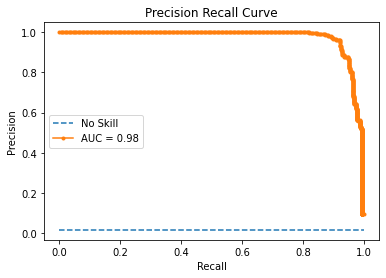

<Figure size 432x288 with 0 Axes>

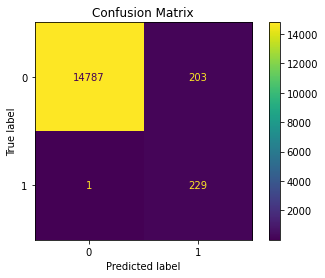

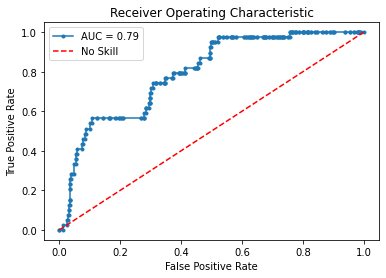

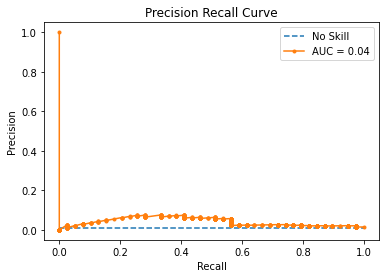

<Figure size 432x288 with 0 Axes>

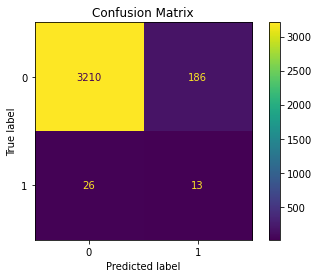

<Figure size 432x288 with 0 Axes>

time: 2h 21min 25s (started: 2021-11-30 15:37:48 +00:00)


In [20]:
combinations = [
    # [10, 10],
    # # [5, 10],
    [1, 10],
    # [1, 5],
    # [1, 1]
]

cols = [
  'DATE', 'CPU', 'CPU COUNT',	'GPU', 'GPU RAM',	'RAM',	'CUDA',	
  'REF', 'DATASET', 'ARCHITECTURE',	
  'SPLIT',	'TARGET',	'ACCURACY',	'ROC',	'PRC',
  'ROC_VALUES', 'PRC_VALUES',
  'TRAIN ROC',	'TRAIN PRC',	'EPISODES',	'TRAINING TIME'
]

load_from_saved = False

for comb in combinations:
  n_pos = comb[0]
  n_neg = comb[1]
  results = pd.DataFrame(columns=cols)

  print(f"\nRUNNING {n_pos}+/{n_neg}-")

  if load_from_saved:
    encoder = GCN(177, 128)
    lstm = ResiLSTMEmbedding(n_pos+n_neg)
    matching_net = MatchingNet()
    encoder.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}.pt"))
    lstm.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_lstm_pos{n_pos}_neg{n_neg}.pt"))
    matching_net.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_mn_pos{n_pos}_neg{n_neg}.pt"))
    encoder.to(device)
    lstm.to(device)
    matching_net.to(device)
  else:
    encoder, lstm, matching_net, train_info = train(train_tasks, train_dfs, balanced_queries, n_pos, n_neg, n_query, episodes, lr)

    if with_bonds:
      torch.save(encoder.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}_bonds.pt")
      torch.save(lstm.state_dict(), f"{drive_path}/{method_dir}/{dataset}_lstm_pos{n_pos}_neg{n_neg}_bonds.pt")
      torch.save(matching_net.state_dict(), f"{drive_path}/{method_dir}/{dataset}_mn_pos{n_pos}_neg{n_neg}_bonds.pt")
    else:
      torch.save(encoder.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}.pt")
      torch.save(lstm.state_dict(), f"{drive_path}/{method_dir}/{dataset}_lstm_pos{n_pos}_neg{n_neg}.pt")
      torch.save(matching_net.state_dict(), f"{drive_path}/{method_dir}/{dataset}_mn_pos{n_pos}_neg{n_neg}.pt")
    
    loss_plot = plt.plot(train_info['losses'])[0]
    loss_plot.figure.savefig(f"{drive_path}/{method_dir}/loss_plots/{dataset}_pos{n_pos}_neg{n_neg}.png")
    plt.figure().clear()

  # test_rounds
  targets, preds, test_info = test(encoder, lstm, matching_net, test_tasks, test_dfs, n_pos, n_neg, test_rounds)

  dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  cpu = get_cmd_output('cat /proc/cpuinfo | grep -E "model name"')
  cpu = cpu.split('\n')[0].split('\t: ')[-1]
  cpu_count = psutil.cpu_count()
  cuda_version = get_cmd_output('nvcc --version | grep -E "Build"')
  gpu = get_cmd_output("nvidia-smi -L")
  general_ram_gb = humanize.naturalsize(psutil.virtual_memory().available)
  gpu_ram_total_mb = GPU.getGPUs()[0].memoryTotal

  for target in test_info:
    if load_from_saved:
      rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                          dataset, {method_dir}, f"{n_pos}+/{n_neg}-", target, 0, test_info[target]['roc'], test_info[target]['prc'], 
                           test_info[target]['roc_values'], test_info[target]['prc_values'],
                          99, 99, 99, 102]], columns=cols)
  
      results = pd.concat([results, rec])
    else:
      rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                          dataset, {method_dir}, f"{n_pos}+/{n_neg}-", target, 0, test_info[target]['roc'], test_info[target]['prc'],
                           test_info[target]['roc_values'], test_info[target]['prc_values'],
                          train_info["train_roc"], train_info["train_prc"], train_info["episodes"], train_info["duration"]
            ]], columns=cols)
  
      results = pd.concat([results, rec])

  if load_from_saved:
    results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}_from_saved.csv", index=False)
  else:
    results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}.csv", index=False)